In [45]:
import pandas as pd
ee2_performance = pd.read_csv("DatabaseClean/EE2_K62_K63_K64_performance.csv")
ee2_performance= ee2_performance.dropna(subset=['student_id'])
ee2_performance['GPA'] = pd.to_numeric(ee2_performance['GPA'], errors='coerce')
warning_mapping = {"Mức 0": 0, "Mức 1": 1, "Mức 2": 2, "Mức 3": 3}
ee2_performance['Warning_Encoded'] = ee2_performance["Warning"].map(warning_mapping)
ee2_performance['Debt_ratio'] = ee2_performance['Debt'] / (ee2_performance['TC qua'] + 1e-6) 


In [46]:
# Cell 2: Tạo nhãn và lọc dữ liệu
df = ee2_performance.copy()

# Sắp xếp dữ liệu theo student_id và Relative Term
df = df.sort_values(['student_id', 'Relative Term'])

# Lấy 7 kỳ đầu tiên cho mỗi sinh viên
df = df.groupby('student_id').head(7)

# Lọc chỉ giữ lại sinh viên có đủ 7 kỳ
student_terms = df.groupby('student_id').size()
valid_students = student_terms[student_terms == 7].index
df = df[df['student_id'].isin(valid_students)]

# Tạo nhãn
df['Label'] = (
    (df.groupby('student_id')['Warning_Encoded'].shift(-1) - df['Warning_Encoded'])
    .apply(lambda x: 0 if x == 0 else (1 if x > 0 else 2))
)

In [47]:
import numpy as np

# GPA trung bình 3 kỳ gần nhất
window_size = 3
df['GPA_rolling_mean'] = df.groupby('student_id')['GPA'].transform(
    lambda x: x.rolling(window_size, min_periods=1).mean()
)

# Tổng số tín nợ tích lũy
df['Cumulative_Debt'] = df.groupby('student_id')['Debt'].cumsum()

# Số lần bị cảnh cáo trong 5 kỳ gần nhất
df['Warning_count_5_terms'] = df.groupby('student_id')['Warning_Encoded'].transform(
    lambda x: x.rolling(5, min_periods=1).apply(lambda y: (y > 0).sum())
)

def calculate_trend(series):
    series = series.dropna()
    if len(series) < 2:
        return 0
    x = np.arange(len(series))
    slope = np.polyfit(x, series, 1)[0]
    return slope

df['GPA_trend'] = df.groupby('student_id')['GPA'].transform(
    lambda x: calculate_trend(x)
)

In [34]:
# # Cell 4: Hàm chia train-test
# from sklearn.model_selection import train_test_split

# def train_test_split_by_student(df, test_size=0.1, random_state=42):
#     """
#     Chia tập train-test theo học sinh, sử dụng 6 kỳ đầu làm features và kỳ 7 làm label
#     """
#     features = ['GPA', 'CPA', 'Debt', 'Cumulative_Debt', 'GPA_rolling_mean', 
#                 'Warning_count_5_terms', 'GPA_trend', 'Reg', 'Debt_ratio']
    
#     # Tạo DataFrame cho features (6 kỳ đầu)
#     feature_data = []
#     labels = []
    
#     for student_id in df['student_id'].unique():
        
#         student_data = df[df['student_id'] == student_id].reset_index(drop=True)
        
#         # Lấy features của 6 kỳ đầu
#         student_features = student_data[features].iloc[:6].values.flatten()
#         feature_data.append(student_features)
        
#         # Lấy label (thay đổi cảnh cáo) của kỳ 6 (dự đoán cho kỳ 7)
#         label = student_data['Label'].iloc[5]  # Label của kỳ 6
#         labels.append(label)
    
#     feature_data = np.array(feature_data)
#     labels = np.array(labels)
    
#     # Chia theo sinh viên
#     unique_students = df['student_id'].unique()
#     train_students, test_students = train_test_split(
#         np.arange(len(unique_students)), 
#         test_size=test_size, 
#         random_state=random_state
#     )
    
#     X_train = feature_data[train_students]
#     X_test = feature_data[test_students]
#     y_train = labels[train_students]
#     y_test = labels[test_students]
    
#     return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test = train_test_split_by_student(df, test_size=0.1,random_state=42)


In [ ]:
# from lightgbm import LGBMClassifier
# from sklearn.metrics import classification_report


# model = LGBMClassifier(
#     scale_pos_weight=10,
#     objective='multiclass',
#     num_class=3,    
#     class_weight='balanced',
#     num_leaves=63,
#     max_depth=7,
#     min_child_samples=20,
#     reg_alpha=0.1,
#     reg_lambda=0.1,
#     learning_rate=0.05,
#     n_estimators=500,
#     metric='multi_logloss',
#     boosting_type='gbdt',
#     data_sample_strategy='goss',
# )

# model.fit(X_train, y_train)

# # Đánh giá mô hình
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import classification_report
def train_test_split_by_student(df, test_size=0.2, random_state=42):
    features = ['GPA', 'CPA', 'Debt', 'Cumulative_Debt', 'GPA_rolling_mean', 
                'Warning_count_5_terms', 'GPA_trend', 'Reg', 'Debt_ratio']
    
    # Tạo DataFrame cho features và label
    feature_data = []
    labels = []
    student_ids = []
    
    for student_id in df['student_id'].unique():
        student_data = df[df['student_id'] == student_id].reset_index(drop=True)
        student_features = student_data[features].iloc[:6].values.flatten()
        label = student_data['Label'].iloc[5]
        
        feature_data.append(student_features)
        labels.append(label)
        student_ids.append(student_id)
    
    feature_data = np.array(feature_data)
    labels = np.array(labels)
    
    # Chia train/test có stratify
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(feature_data, labels))
    
    return feature_data[train_idx], feature_data[test_idx], labels[train_idx], labels[test_idx]
X_train, X_test, y_train, y_test = train_test_split_by_student(df, test_size=0.1,random_state=42)

In [50]:
from lightgbm import LGBMClassifier

# Cell kiểm tra dữ liệu
print("1. Kiểm tra số lượng sinh viên và phân bố dữ liệu:")
print(f"Tổng số sinh viên: {len(df['student_id'].unique())}")
print("\nPhân bố nhãn:")
print(df['Label'].value_counts(normalize=True))

print("\n2. Kiểm tra features:")
features = ['GPA', 'CPA', 'Debt', 'Cumulative_Debt', 'GPA_rolling_mean', 
           'Warning_count_5_terms', 'GPA_trend', 'Reg', 'Debt_ratio']
print("\nKiểm tra giá trị NaN trong features:")
print(df[features].isnull().sum())

print("\n3. Kiểm tra shape của train-test:")
X_train, X_test, y_train, y_test = train_test_split_by_student(df, test_size=0.1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\nPhân bố nhãn trong tập train:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nPhân bố nhãn trong tập test:")
print(pd.Series(y_test).value_counts(normalize=True))

# Huấn luyện và đánh giá
model = LGBMClassifier(
    objective='multiclass',
    num_class=3,    
    class_weight='balanced',
    num_leaves=31,  # giảm xuống để tránh overfit
    max_depth=5,    # giảm xuống để tránh overfit
    min_child_samples=30,  # tăng lên để ổn định hơn
    reg_alpha=0.5,  # tăng regularization
    reg_lambda=0.5, # tăng regularization
    learning_rate=0.01,  # giảm để học chậm hơn
    n_estimators=1000,   # tăng số cây
    boosting_type='gbdt',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n4. Kết quả phân loại chi tiết:")
print(classification_report(y_test, y_pred))

# Kiểm tra feature importance
print("\n5. Top 10 features quan trọng nhất:")
feature_names = []
for f in features:
    feature_names.extend([f"{f}_term_{i+1}" for i in range(6)])
    
importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
})
print(importance.sort_values('importance', ascending=False).head(10))

1. Kiểm tra số lượng sinh viên và phân bố dữ liệu:
Tổng số sinh viên: 1432

Phân bố nhãn:
Label
0    0.807263
2    0.161911
1    0.030826
Name: proportion, dtype: float64

2. Kiểm tra features:

Kiểm tra giá trị NaN trong features:
GPA                      17
CPA                       0
Debt                      0
Cumulative_Debt           0
GPA_rolling_mean          1
Warning_count_5_terms     0
GPA_trend                 0
Reg                       0
Debt_ratio                0
dtype: int64

3. Kiểm tra shape của train-test:
X_train shape: (1288, 54)
X_test shape: (144, 54)

Phân bố nhãn trong tập train:
0    0.943323
1    0.033385
2    0.023292
Name: proportion, dtype: float64

Phân bố nhãn trong tập test:
0    0.944444
1    0.034722
2    0.020833
Name: proportion, dtype: float64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6107
[LightGBM] 

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Đánh giá bằng cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_val)
    
    print(f"\nFold {fold + 1}:")
    print(classification_report(y_fold_val, y_fold_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_fold_val, y_fold_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5878
[LightGBM] [Info] Number of data points in the train set: 1030, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train set: 1030, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

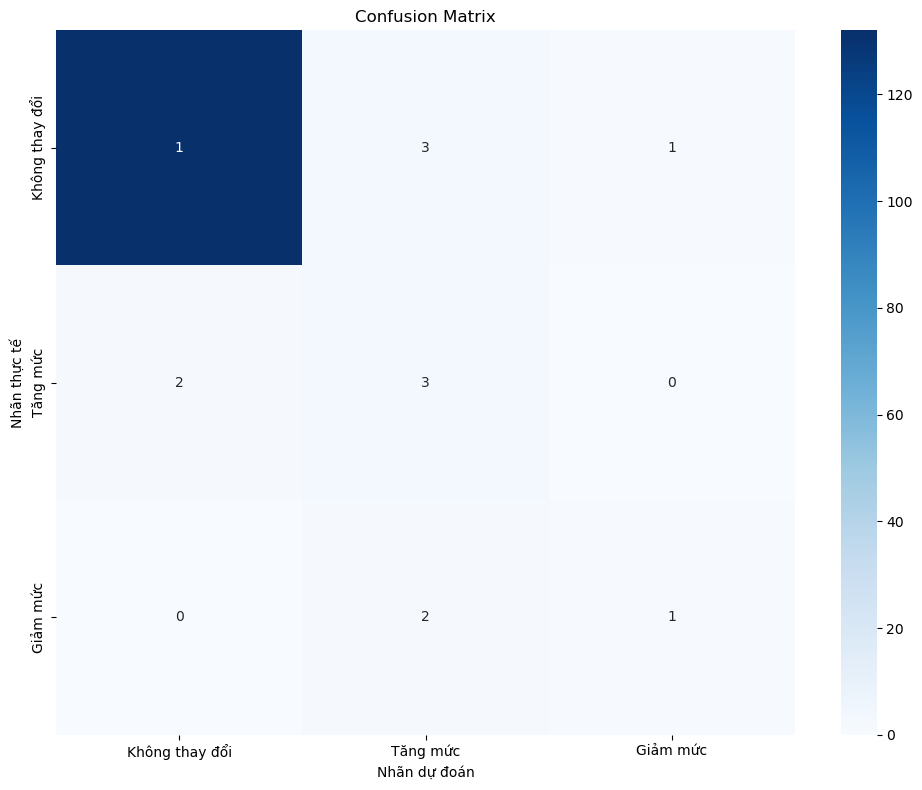

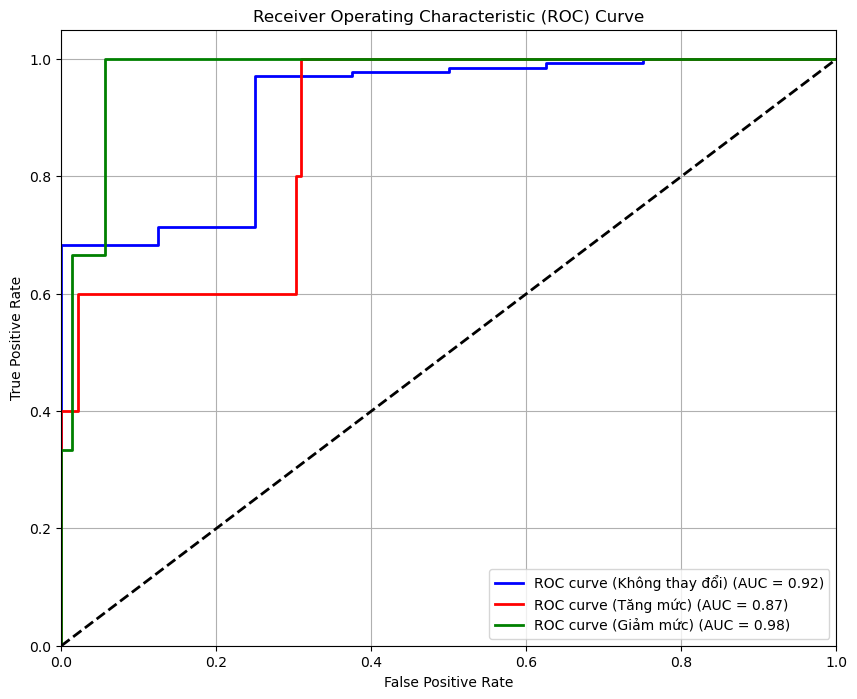

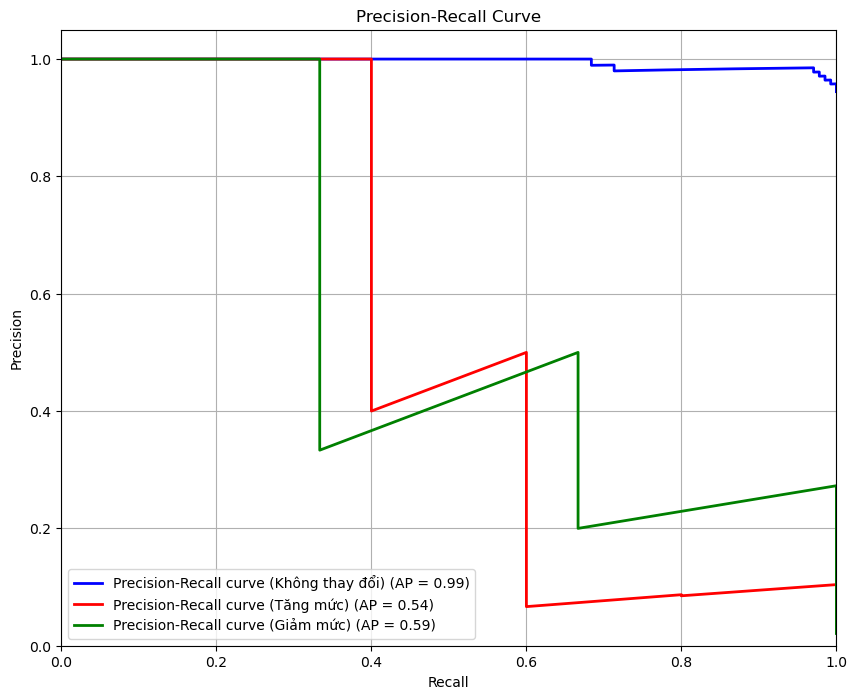

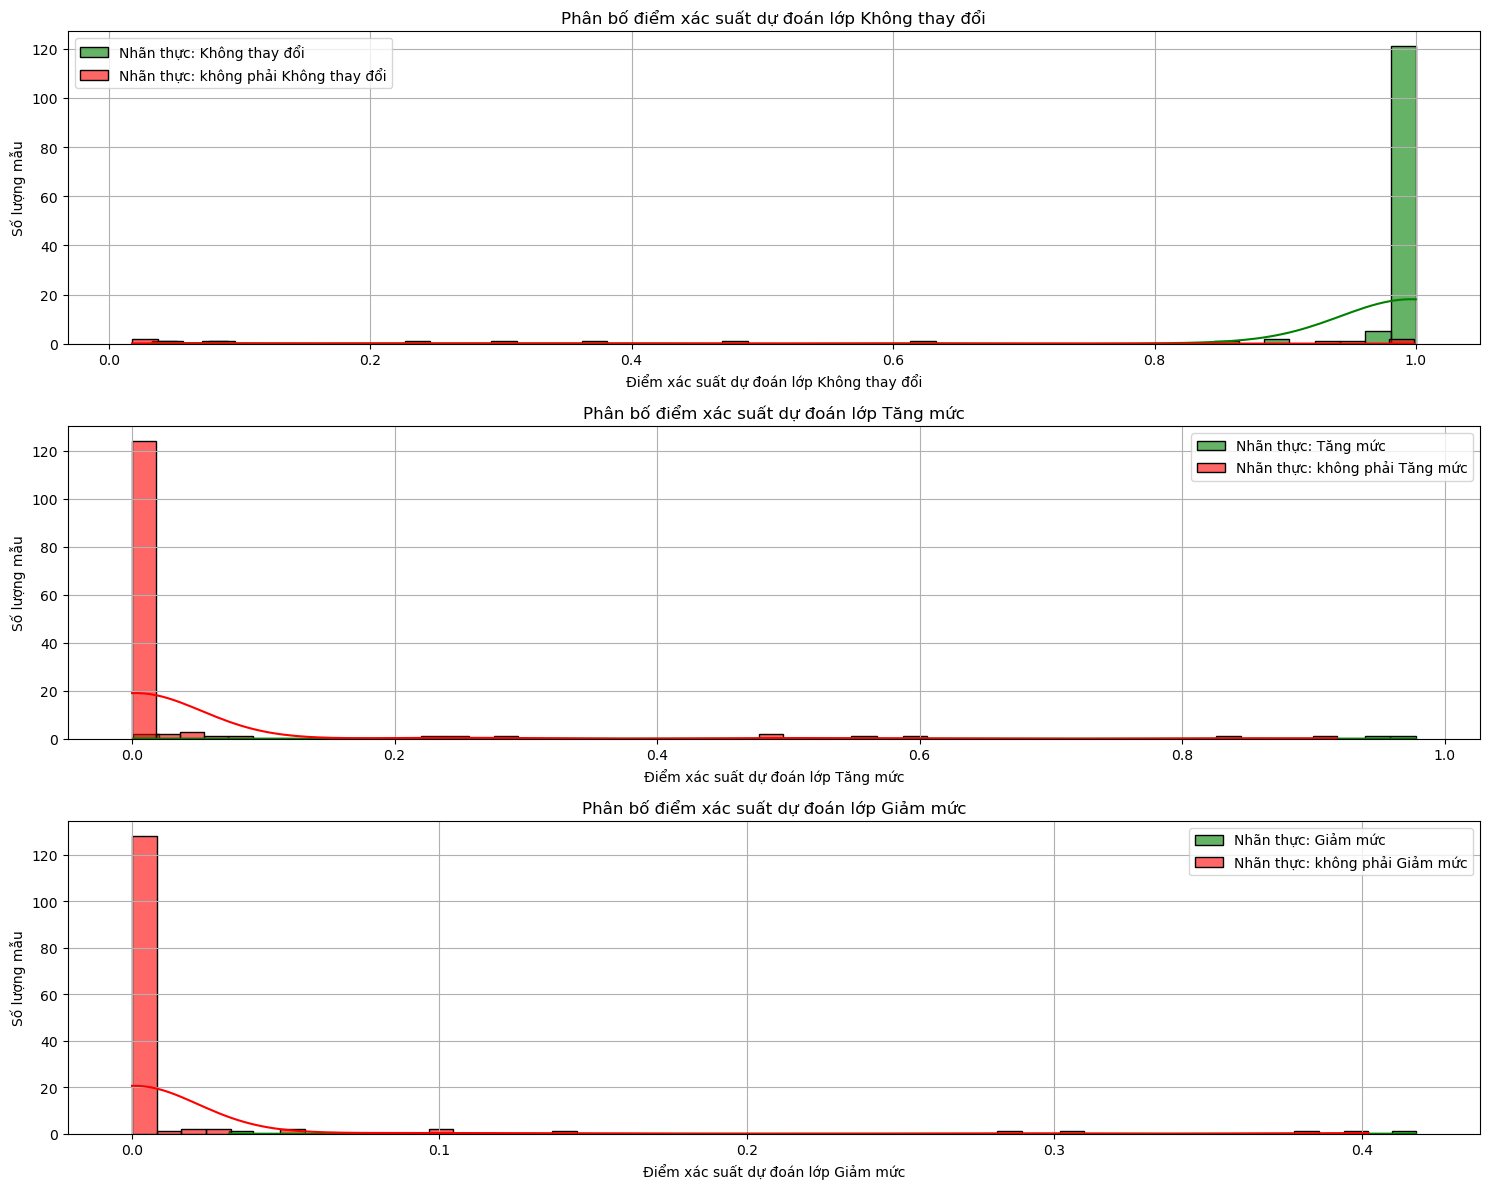



2. Kết quả Cross-Validation trên tập Train:


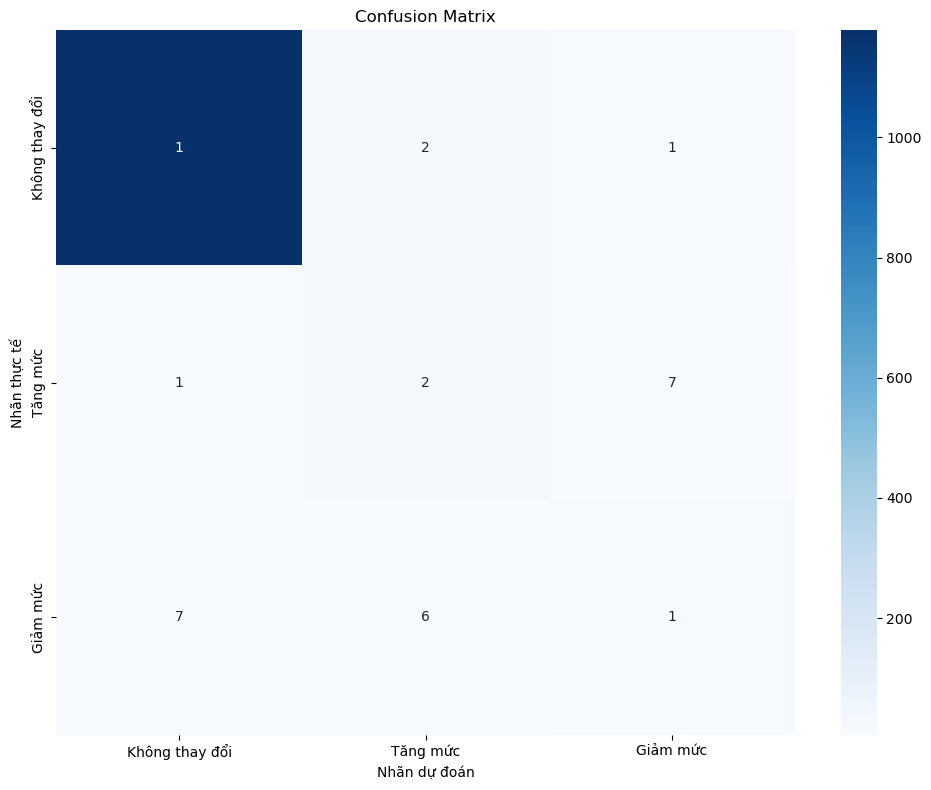

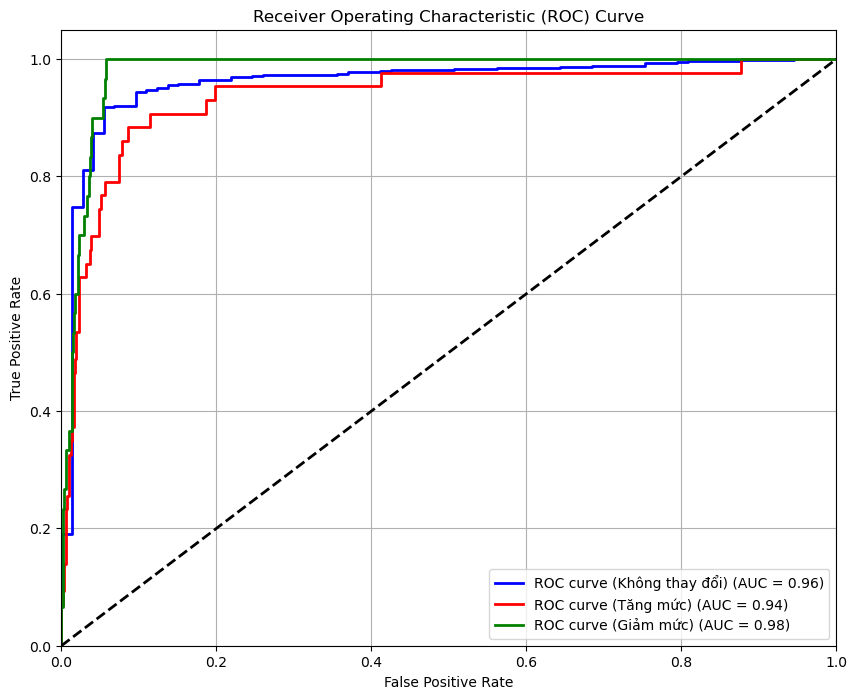

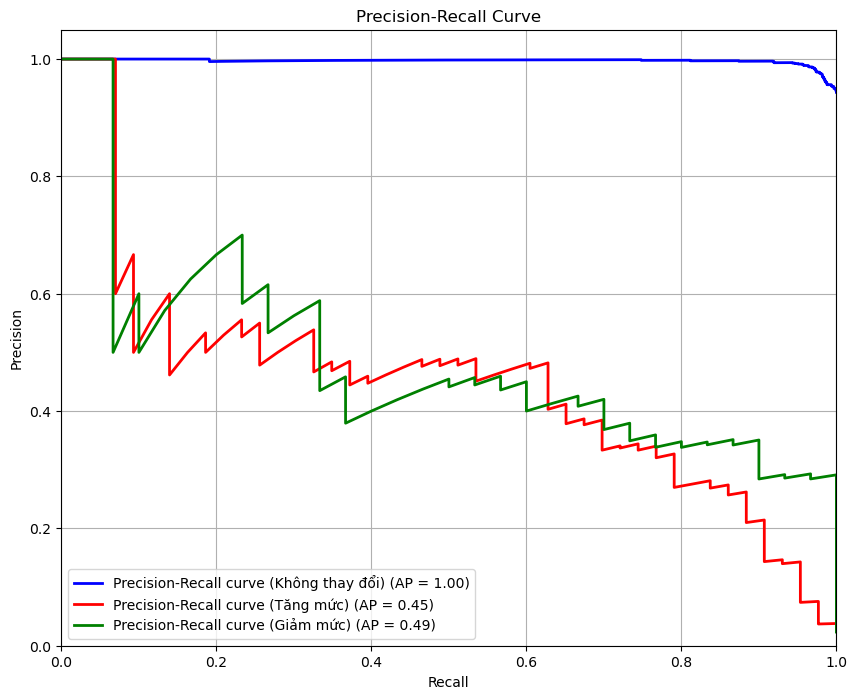



3. Feature Importance:


C:\Users\Legion\AppData\Local\Temp\ipykernel_8676\2758401968.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


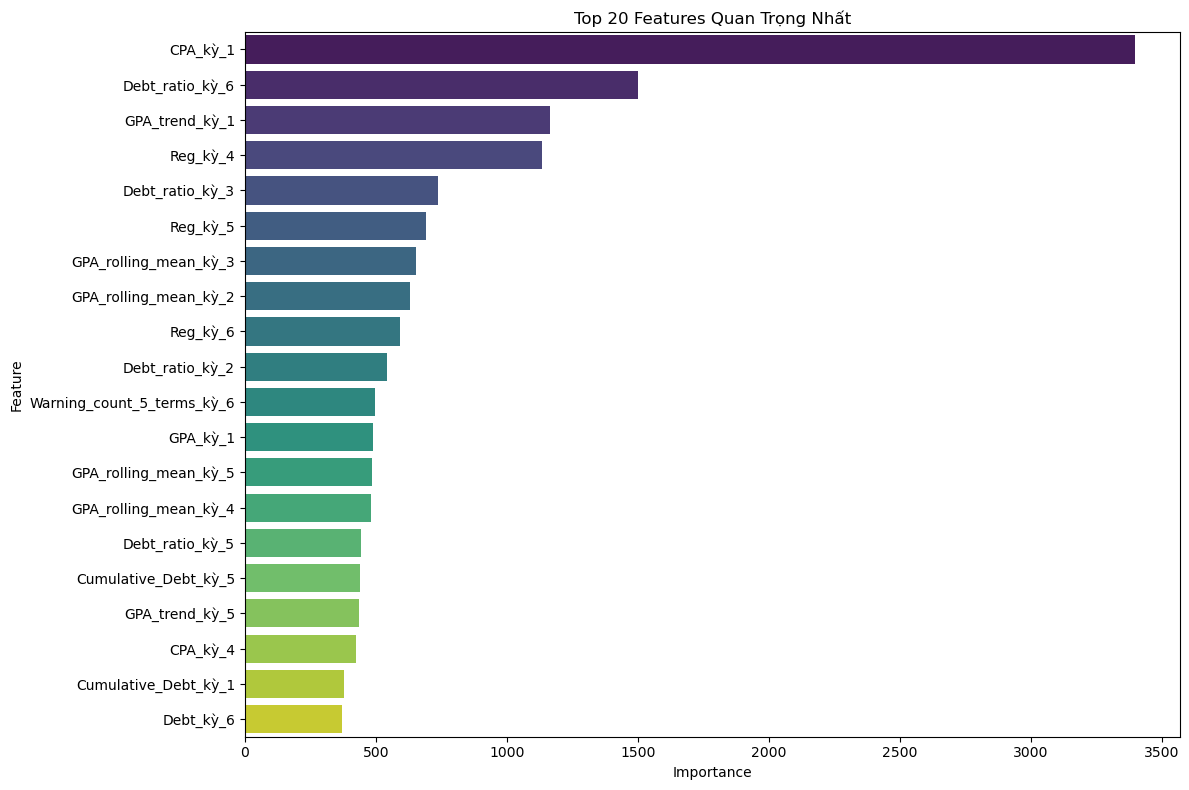

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_predict

# 1. Vẽ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names=['Không thay đổi', 'Tăng mức', 'Giảm mức']):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    
    # Tính % theo hàng
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Tạo annotations cho heatmap
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# 2. Vẽ ROC Curve và AUC
def plot_roc_curves(y_true, y_pred_proba, class_names=['Không thay đổi', 'Tăng mức', 'Giảm mức']):
    n_classes = len(class_names)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Tính toán ROC curve và AUC cho từng class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Vẽ ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    
    for i, color, name in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve ({name}) (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return roc_auc

# 3. Vẽ Precision-Recall Curve
def plot_precision_recall_curves(y_true, y_pred_proba, class_names=['Không thay đổi', 'Tăng mức', 'Giảm mức']):
    n_classes = len(class_names)
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    # Tính toán Precision-Recall curve cho từng class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_true == i, y_pred_proba[:, i])
    
    # Vẽ Precision-Recall curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    
    for i, color, name in zip(range(n_classes), colors, class_names):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Precision-Recall curve ({name}) (AP = {average_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
    return average_precision

# 4. Feature Importance
def plot_feature_importance(model, feature_names, top_n=20):
    # Lấy feature importance từ model
    importance = model.feature_importances_
    
    # Tạo DataFrame để sắp xếp
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Chỉ lấy top N features
    top_features = feature_importance.head(top_n)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.title(f'Top {top_n} Features Quan Trọng Nhất')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# 5. Phân bố điểm xác suất dự đoán theo từng class
def plot_prediction_distribution(y_true, y_pred_proba, class_names=['Không thay đổi', 'Tăng mức', 'Giảm mức']):
    n_classes = len(class_names)
    
    plt.figure(figsize=(15, 4 * n_classes))
    
    for i in range(n_classes):
        plt.subplot(n_classes, 1, i+1)
        
        # Tách điểm xác suất theo nhãn thực tế
        scores_true = y_pred_proba[y_true == i, i]
        scores_false = y_pred_proba[y_true != i, i]
        
        # Vẽ histogram
        if len(scores_true) > 0:
            sns.histplot(scores_true, color='green', label=f'Nhãn thực: {class_names[i]}', 
                         alpha=0.6, bins=50, kde=True)
        if len(scores_false) > 0:
            sns.histplot(scores_false, color='red', label=f'Nhãn thực: không phải {class_names[i]}', 
                         alpha=0.6, bins=50, kde=True)
        
        plt.xlabel(f'Điểm xác suất dự đoán lớp {class_names[i]}')
        plt.ylabel('Số lượng mẫu')
        plt.title(f'Phân bố điểm xác suất dự đoán lớp {class_names[i]}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Sử dụng các hàm trên với dữ liệu train và test
def evaluate_model_with_plots(model, X_train, y_train, X_test, y_test, feature_names=None):
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Tạo cross-validation predictions cho tập train
    cv_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
    cv_pred = np.argmax(cv_pred_proba, axis=1)
    
    class_names = ['Không thay đổi', 'Tăng mức', 'Giảm mức']
    
    print("1. Kết quả trên tập Test:")
    print("=" * 50)
    plot_confusion_matrix(y_test, y_pred, class_names)
    roc_auc = plot_roc_curves(y_test, y_pred_proba, class_names)
    ap = plot_precision_recall_curves(y_test, y_pred_proba, class_names)
    plot_prediction_distribution(y_test, y_pred_proba, class_names)
    
    print("\n\n2. Kết quả Cross-Validation trên tập Train:")
    print("=" * 50)
    plot_confusion_matrix(y_train, cv_pred, class_names)
    plot_roc_curves(y_train, cv_pred_proba, class_names)
    plot_precision_recall_curves(y_train, cv_pred_proba, class_names)
    

    if feature_names is not None:
        print("\n\n3. Feature Importance:")
        print("=" * 50)
        plot_feature_importance(model, feature_names)

# Sử dụng hàm đánh giá tổng hợp
# Tạo tên features cho model
features = ['GPA', 'CPA', 'Debt', 'Cumulative_Debt', 'GPA_rolling_mean', 
            'Warning_count_5_terms', 'GPA_trend', 'Reg', 'Debt_ratio']

feature_names = []
for f in features:
    feature_names.extend([f"{f}_kỳ_{i+1}" for i in range(6)])

# Đánh giá model với đồ thị
results = evaluate_model_with_plots(model, X_train, y_train, X_test, y_test, feature_names)